In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style("whitegrid")

## Objective

In [2]:
def create_objective(target: float = 0.45):
    def objective(b):
        return (b - target) ** 2
    return objective

## Helpers for REBAR

In [3]:
def log_pb_bern(b, theta):
    """ Log probability of Bernoulli distribution. """
    return torch.log(theta) * b + torch.log(1 - theta) * (1 - b)

b = torch.tensor([1]) 
theta = torch.tensor([0.43], requires_grad=True)
log_pb_value = log_pb_bern(b, theta)

autograd.grad(log_pb_value, theta)

(tensor([2.3256]),)

In [4]:
def g(u, theta):
    """ 
    Differentiable reparametrization of z.

    Givem u ~ U(0, 1), and theta from (0, 1).
    Return a sample from p(z). Logistic distribution.
    """
    return torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))


def g_tilde(v, b, theta):
    """
    Differentiable reparametrization of z|b.

    Given v ~ U(0, 1), b ~ Bernoulli(theta).
    and theta from (0, 1).

    Return a sample from the distribution p(z|b).
    """
    zb1 = torch.log((v / (1 - v)) * (1/(1-theta)) + 1)
    zb0 = -torch.log((v / (1 - v)) * (1/theta) + 1)
    return torch.where(b == 1, zb1, zb0)


def H(z):
    """
    The hard threshold function.
    """
    return torch.where(z >= 0, 1, 0)


def sigma(z, lmbda = 1):
    """
    Sigmoid with a temperature parameter.
    """
    return torch.sigmoid(z / lmbda) + 1e-9


def g_lmbda(u, theta, lmbda = 1):
    """
    Differentiable reparametrization of z_lmbda.

    After sigma this makes an alternative to sigma(g(u, theta), lmbda).
    lmbda must be the same for both g_lmbda and sigma.
    """
    quadratic = (lmbda**2 + lmbda + 1)/(lmbda + 1)
    z_lmbda = quadratic * torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))
    return z_lmbda

# Compare

In [5]:
def binary_log_likelihood(y, theta):
    log_y_hat = torch.log(theta + 1e-9)
    # standard LL for vectors of binary labels y and log predictions log_y_hat
    return (y * -F.softplus(-log_y_hat)) + (1 - y) * (-log_y_hat - F.softplus(-log_y_hat))

In [ ]:
max_iter = 5000
target = 0.45
f = create_objective(target=target)
log_pb = binary_log_likelihood

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [32]:
class ThetaModel(nn.Module):
    def __init__(self, theta_init=0.5):
        super(ThetaModel, self).__init__()
        self.inner_theta = nn.Parameter(torch.tensor([theta_init], dtype=torch.float32))

    def forward(self):
        return F.sigmoid(self.inner_theta)

In [74]:
losses = []
variances = []
grad_estimates_list = []
etas = []
lmbdas = []
thetas = []
rebar_before_grads = []

n_variance_samples = 128  # N.o samples to compute variance

lmbda = torch.tensor([0.5], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)

theta_model = ThetaModel()
theta_model.train()

opt = torch.optim.Adam([theta_model.inner_theta], lr=0.005, betas=(0.9, 0.99999))
opt2 = torch.optim.Adam([lmbda, eta], lr=0.1, betas=(0.99, 0.99999))

for _ in tqdm(range(max_iter)):

    # Initialize theta
    theta = theta_model.forward()

    temp_theta = theta.detach().clone().repeat(n_variance_samples, 1)
    temp_theta.requires_grad = True

    # Batch sampling
    u = torch.rand(n_variance_samples, 1) + 1e-9
    v = torch.rand(n_variance_samples, 1) + 1e-9
    z = g(u, temp_theta)
    b = H(z).detach()
    z_tilde = g_tilde(v, b, temp_theta)

    first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, temp_theta)
    second_term = eta * f(sigma(z, lmbda))
    third_term = -eta * f(sigma(z_tilde, lmbda))
    rebar_before_grad = first_term + second_term + third_term
    rebar_before_grads.append(rebar_before_grad[0].detach().item())

    grad_estimates = torch.autograd.grad(rebar_before_grad.mean(), temp_theta, create_graph=True)[0]

    losses.append(f(torch.bernoulli(temp_theta.detach())).mean().item())
    variances.append(torch.var(grad_estimates.detach()).item())

    # Take one sample Monte Carlo estimate of the gradient
    gradient_estimate = grad_estimates[0]
    grad_estimates_list.append(gradient_estimate.detach().item())

    opt.zero_grad()
    opt2.zero_grad()
    eta.grad, lmbda.grad = torch.autograd.grad(torch.mean(grad_estimates[0] ** 2), (eta, lmbda))
    autograd.backward(theta, gradient_estimate.detach())
    opt.step()
    opt2.step()

    lmbda.data = torch.clamp(lmbda.data, 0.001)

    thetas.append(theta.detach().item())
    etas.append(eta.detach().item())
    lmbdas.append(lmbda.detach().item())

    if torch.isnan(theta).any():
        print("NaN detected")
        break


100%|██████████| 5000/5000 [00:09<00:00, 552.89it/s]


Text(0.5, 1.0, 'Lambda over iterations')

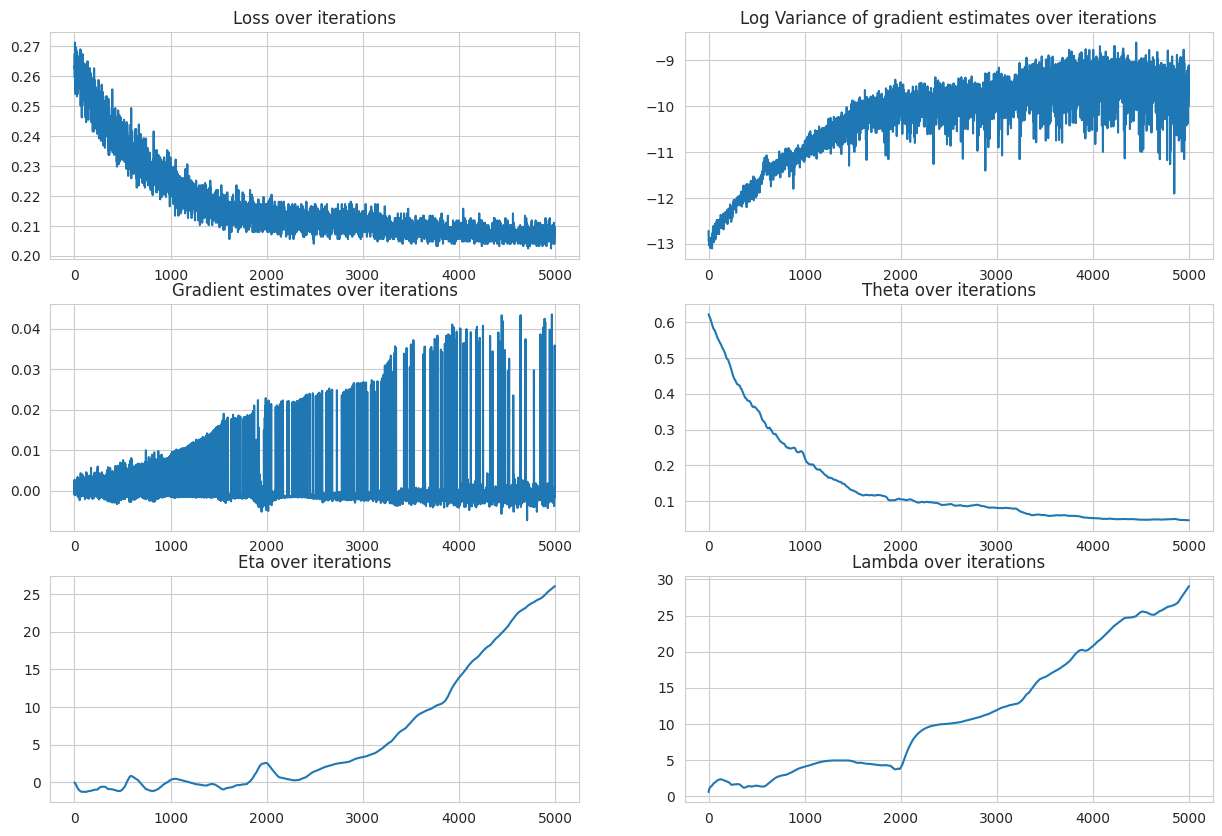

In [72]:
# Create a single figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Plot the loss
sns.lineplot(x=range(len(losses)), y=losses, ax=axs[0][0])
axs[0][0].set_title('Loss over iterations')
sns.lineplot(x=range(len(losses)), y=np.log(np.array(variances)), ax=axs[0][1])
axs[0][1].set_title('Log Variance of gradient estimates over iterations')
sns.lineplot(x=range(len(grad_estimates_list)), y=grad_estimates_list, ax=axs[1][0])
axs[1][0].set_title('Gradient estimates over iterations')
sns.lineplot(x=range(len(thetas)), y=thetas, ax=axs[1][1])
axs[1][1].set_title('Theta over iterations')
sns.lineplot(x=range(len(etas)), y=etas, ax=axs[2][0])
axs[2][0].set_title('Eta over iterations')
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, ax=axs[2][1])
axs[2][1].set_title('Lambda over iterations')
